In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

# Prefer absolute paths on the cluster
PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'prostate_baseline'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

# Ensure local package imports work
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Set environment variables for local cache directories
os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config (prostate)
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / dataset_name).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

# Placeholders; will be finalized after inspection cells
gene_col = 'gene_symbols'
batch_col = 'sample'     # to be validated
label_col = 'cell_type'  # to be validated
layer_key = 'X'

RUN_TAG = 'full'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V2-104M_CLcancer').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 16
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-09 01:48:36 | Using device cuda
INFO     | 2025-08-09 01:48:36 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer


In [5]:
# Inspect dataset to determine columns and structure
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

if 'gene_symbols' in ad.var.columns:
    gene_col = 'gene_symbols'
else:
    gene_col = None
print('gene_col ->', gene_col if gene_col else 'var.index')

print('n unique labels:', ad.obs[label_col].nunique() if label_col in ad.obs else 'NA')
print('label example counts:\n', ad.obs[label_col].astype(str).value_counts().head(20) if label_col in ad.obs else 'NA')


adata shape: (36424, 25044)
obs columns: ['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'sample_technology', 'sample_n_cells', 'sample_patient', 'sample_cancer_type', 'sample_sex', 'sample_age', 'sample_smoking_status', 'sample_PY', 'sample_diagnosis_recurrence', 'sample_disease_extent', 'sample_AJCC_T', 'sample_AJCC_N', 'sample_AJCC_M', 'sample_AJCC_stage', 'sample_sample_primary_met', 'sample_size', 'sample_site', 'sample_histology', 'sample_genetic_hormonal_features', 'sample_grade', 'sample_KI67', 'sample_treated_naive', 'sample_chemotherapy_exposed', 'sample_chemotherapy_response', 'sample_targeted_rx_exposed', 'sample_targeted_rx_response', 'sample_ICB_exposed', 'sample_ICB_response', 'sample_ET_exposed', 'sample_ET_response', 'sample_time_end_of_rx_to_sampling', 'sample_post_sampling_rx_exposed', 'sample_post_sampling_rx_response', 'sample_PFS_DFS', 'sample_OS', 'n_genes_by_counts',

In [6]:
# Load and preprocess data to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(in_dataset_path))

inp.preprocess_data(
    gene_col=gene_col if gene_col else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_path = preprocessed_path / f'{dataset_name}.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-09 01:48:50 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad
WARNING  | 2025-08-09 01:48:59 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-09 01:49:02 | Matched 76.10% genes (16593/21804) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3/prostate_cancer_with_celltypes_v3.h5ad exists: True


In [7]:
# Verify/update columns post-preprocess
import scanpy as sc
pfile = str(preprocessed_path / f'{dataset_name}.h5ad')

ad_tmp = sc.read(pfile)
if 'cell_type' not in ad_tmp.obs.columns and label_col in ad_tmp.obs.columns:
    ad_tmp.obs['cell_type'] = ad_tmp.obs[label_col].astype(str).values
    print("Added 'cell_type' column from:", label_col)
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3/prostate_cancer_with_celltypes_v3.h5ad


In [8]:
# Tokenize to HF Dataset on disk and persist

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col=label_col
)

dataset_dir = preprocessed_path / f'{dataset_name}.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name,
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': label_col,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}.dataset')
print('Archived tokenized dataset to:', archive_path)


WARNING  | 2025-08-09 01:49:28 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3/prostate_cancer_with_celltypes_v3.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3/prostate_cancer_with_celltypes_v3.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 36424
Sample input_ids length: 2393


Setting num_proc from 24 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3/prostate_cancer_with_celltypes_v3.dataset exists: True
save_to_disk skipped: Tried to overwrite /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3/prostate_cancer_with_celltypes_v3.dataset but a dataset can't overwrite itself.
Saved row_order.csv
Saved manifest.json
Archived tokenized dataset to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/prostate_cancer_with_celltypes_v3.dataset.tar.gz


In [9]:
# Load back, extract embeddings, and quick eval

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key=label_col,
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


Geneformer (extracting embeddings): 100%|██████████| 2277/2277 [46:21<00:00,  1.22s/it] 
DEBUG    | 2025-08-09 02:38:30 | Extracting output from 500 cells
WARNING  | 2025-08-09 02:38:39 | adata_ has 36424 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-09 02:38:39 | Computing metrics for cell_type
DEBUG    | 2025-08-09 02:38:43 | NMI_cluster/label: 0.4192
ARI_cluster/label: 0.2800
ASW_label: 0.4982
graph_conn: 0.9242
ASW_batch: 0.4133
ASW_label/batch: 0.7578
PCR_batch: 0.0292
avg_bio: 0.3991
DEBUG    | 2025-08-09 02:38:43 | NMI_cluster/label for cell_type: 0.4192048447205866
DEBUG    | 2025-08-09 02:38:43 | ARI_cluster/label for cell_type: 0.2800489927561629
DEBUG    | 2025-08-09 02:38:43 | ASW_label for cell_type: 0.4981524646282196
DEBUG    | 2025-08-09 02:38:43 | graph_conn for cell_type: 0.9242234478810549
DEBUG    | 2025-08-09 02:38:43 | ASW_batch for cell_type: 0.4132731258869171
DEBUG    | 2025-08-09 02:38:43 | ASW_label/batch for cell_type: 0.7577868103981018
DEBUG    

,metric,label,value
0,NMI_cluster/label,cell_type,0.419205
1,ARI_cluster/label,cell_type,0.280049
2,ASW_label,cell_type,0.498152
3,graph_conn,cell_type,0.924223
4,ASW_batch,cell_type,0.413273
5,ASW_label/batch,cell_type,0.757787
6,PCR_batch,cell_type,0.029171
7,avg_bio,cell_type,0.399135


In [10]:
# Ensemble evaluation and saving
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col=label_col,
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name,
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_prostate_results_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_prostate_metrics_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-09 02:38:43 | Initialized GeneformerEnsembleMetrics with 36424 cells and 9 classes
INFO     | 2025-08-09 02:38:43 | Classes: ['B_cell', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Malignant', 'Mast', 'T_cell', 'Unassigned']
INFO     | 2025-08-09 02:38:43 | Embedding shape: (36424, 768)
INFO     | 2025-08-09 02:38:43 | Input rankings length: 36424
INFO     | 2025-08-09 02:38:43 | Output rankings length: 36424
INFO     | 2025-08-09 02:38:44 | Evaluated embedding_only (α=0.0): Accuracy=0.633, F1=0.630, AUC-ROC=0.775
INFO     | 2025-08-09 02:38:44 | Evaluated embedding_only (α=0.1): Accuracy=0.633, F1=0.630, AUC-ROC=0.775


alpha=0.0: F1=0.630, AUC=0.775, Acc=0.633
alpha=0.1: F1=0.630, AUC=0.775, Acc=0.633


INFO     | 2025-08-09 02:38:44 | Evaluated embedding_only (α=0.3): Accuracy=0.633, F1=0.630, AUC-ROC=0.775


alpha=0.3: F1=0.630, AUC=0.775, Acc=0.633


INFO     | 2025-08-09 02:38:44 | Evaluated embedding_only (α=0.5): Accuracy=0.633, F1=0.630, AUC-ROC=0.775
INFO     | 2025-08-09 02:38:44 | Evaluated embedding_only (α=0.7): Accuracy=0.633, F1=0.630, AUC-ROC=0.775


alpha=0.5: F1=0.630, AUC=0.775, Acc=0.633
alpha=0.7: F1=0.630, AUC=0.775, Acc=0.633


INFO     | 2025-08-09 02:38:45 | Evaluated embedding_only (α=0.9): Accuracy=0.633, F1=0.630, AUC-ROC=0.775


alpha=0.9: F1=0.630, AUC=0.775, Acc=0.633


INFO     | 2025-08-09 02:38:45 | Evaluated embedding_only (α=1.0): Accuracy=0.633, F1=0.630, AUC-ROC=0.775


alpha=1.0: F1=0.630, AUC=0.775, Acc=0.633
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_results_full.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_metrics_full.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_confusion_matrix_full.png


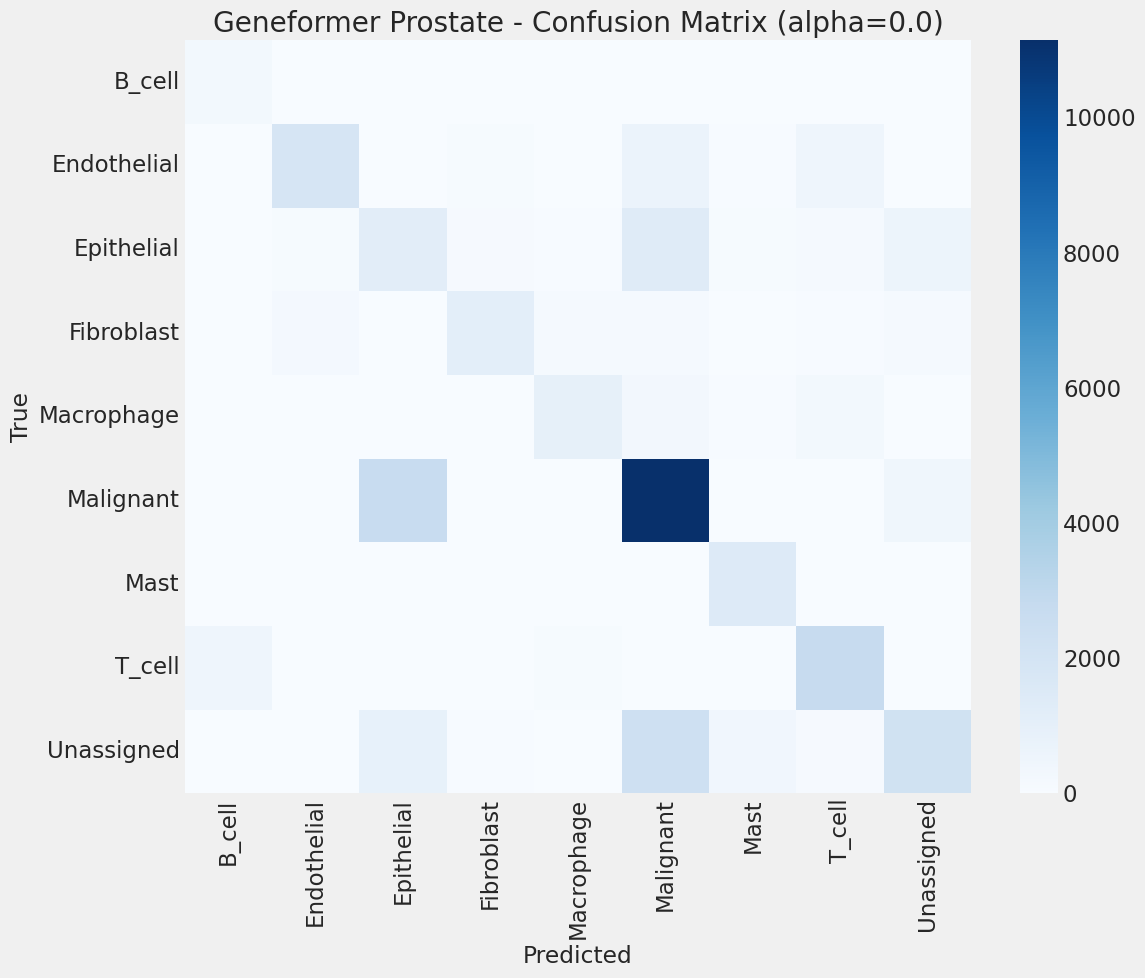

In [11]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names, ax=ax)
ax.set_title(f'Geneformer Prostate - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_prostate_confusion_matrix_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_umap_coords_full.csv


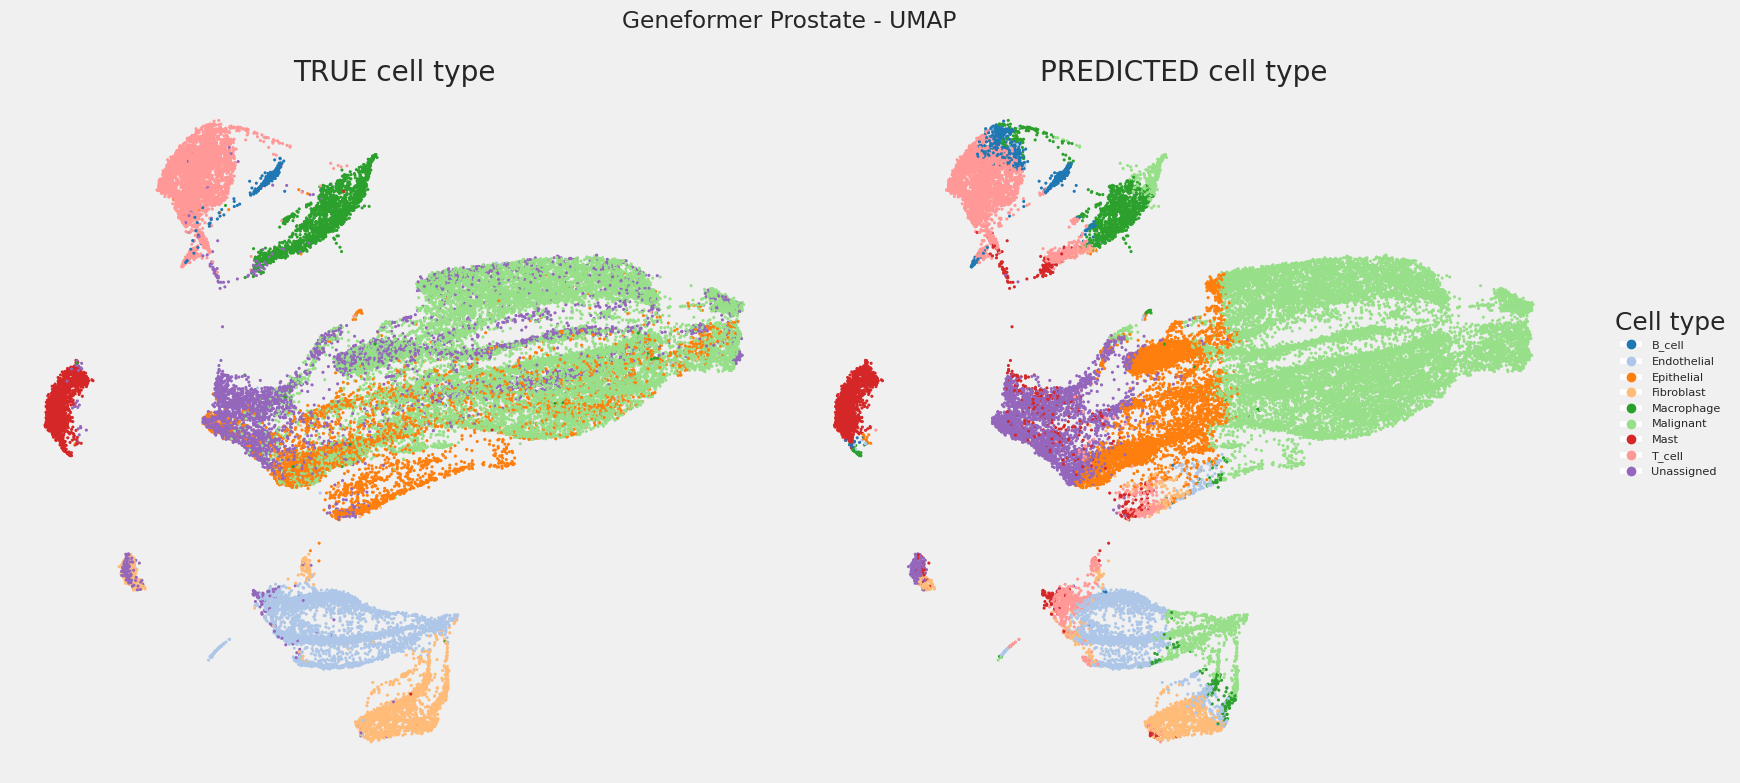

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_baseline/model_outputs/geneformer_prostate_umap_true_pred_with_legend_full.png


In [12]:
# UMAP of true vs predicted labels with side legend
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
class_names = list(em.class_names)
preds_arr = np.asarray(preds)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_names_arr = np.array(class_names, dtype=object)
true_names = class_names_arr[labels_encoded]
pred_names = class_names_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

unique_levels = list(class_names)
if len(unique_levels) <= 20:
    pal_colors = sns.color_palette('tab20', n_colors=len(unique_levels))
else:
    pal_colors = sns.color_palette('hls', n_colors=len(unique_levels))
palette = dict(zip(unique_levels, pal_colors))

coords_path = MODEL_OUT / f'geneformer_prostate_umap_coords_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in unique_levels
]
fig.legend(handles=handles, labels=unique_levels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Prostate - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_prostate_umap_true_pred_with_legend_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [13]:
# Performance metrics summary
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

results_path = MODEL_OUT / f'geneformer_prostate_results_{RUN_TAG}.pt'

res = None
try:
    from torch.serialization import safe_globals, add_safe_globals
    try:
        with safe_globals([np.core.multiarray._reconstruct]):
            res = torch.load(results_path, map_location='cpu')
        print('Loaded results with safe_globals allowlist')
    except Exception:
        add_safe_globals([np.core.multiarray._reconstruct])
        res = torch.load(results_path, map_location='cpu')
        print('Loaded results after add_safe_globals')
except Exception:
    pass
if res is None:
    res = torch.load(results_path, map_location='cpu', weights_only=False)
    print('Loaded results with weights_only=False')

model_name = res.get('model_name', 'UnknownModel')
dataset = res.get('dataset_name', 'UnknownDataset')
best_alpha = res.get('best_alpha', None)
class_names = list(res.get('class_names', []))

labels_t = res['labels']
preds_t = res['preds']
labels_np = labels_t.cpu().numpy() if hasattr(labels_t, 'cpu') else np.array(labels_t)
preds_np = preds_t.cpu().numpy() if hasattr(preds_t, 'cpu') else np.array(preds_t)

print(f'Model: {model_name}')
print(f'Dataset: {dataset}')
if best_alpha is not None:
    print(f'Best alpha (ensemble): {best_alpha}')

metrics = res.get('evaluation_metrics', None)
if metrics is not None:
    print('\nSaved evaluation metrics:')
    for k in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'avg_precision']:
        if k in metrics:
            print(f'  {k}: {metrics[k]:.4f}')
else:
    acc = accuracy_score(labels_np, preds_np)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='macro', zero_division=0)
    print('\nComputed metrics (macro):')
    print(f'  accuracy: {acc:.4f}')
    print(f'  precision: {prec:.4f}')
    print(f'  recall: {rec:.4f}')
    print(f'  f1_score: {f1:.4f}')

if class_names and len(class_names) > int(labels_np.max()):
    target_names = class_names
else:
    n_classes = int(max(labels_np.max(), preds_np.max())) + 1
    target_names = [f'Class_{i}' for i in range(n_classes)]

print('\nClassification report:')
print(classification_report(labels_np, preds_np, target_names=target_names, digits=4))


Loaded results with weights_only=False
Model: Geneformer-V2-104M_CLcancer
Dataset: prostate_cancer_with_celltypes_v3
Best alpha (ensemble): 0.0

Saved evaluation metrics:
  accuracy: 0.6333
  precision: 0.6517
  recall: 0.6333
  f1_score: 0.6296
  auc_roc: 0.7749
  avg_precision: 0.5728

Classification report:
              precision    recall  f1-score   support

      B_cell     0.3231    0.8851    0.4734       322
 Endothelial     0.8229    0.5757    0.6774      3278
  Epithelial     0.2544    0.3218    0.2841      3782
  Fibroblast     0.7717    0.5512    0.6431      2030
  Macrophage     0.6945    0.5823    0.6334      1714
   Malignant     0.6973    0.7796    0.7362     14291
        Mast     0.6785    0.9509    0.7919      1529
      T_cell     0.6935    0.7969    0.7416      3481
  Unassigned     0.6336    0.3653    0.4635      5997

    accuracy                         0.6333     36424
   macro avg     0.6188    0.6454    0.6050     36424
weighted avg     0.6517    0.6333    0